In [102]:
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt

In [103]:
%matplotlib inline
sns.set_style("white")

plt.rcParams.update({
    'figure.autolayout': False,
    'figure.figsize'   : (15,8),
    'ytick.labelsize'  : 15,
    'xtick.labelsize'  : 15,
    'axes.labelsize'   : 20,
    'legend.fontsize'  : 18,
})

### Read data

In [104]:
corpus = 'corpus1'
# corpus = 'corpus5'
path = './%s.txt' % corpus
fig_path = './figures/%s_' % corpus

with open(path, 'r') as f:
    lines = f.readlines()

Use a tokenizer to parse the header

In [105]:
tokenizer = re.compile(r' *\**\w*_')
useful_range = slice(19, -21)

# tokenize an example of header
tokenizer.split(lines[0][useful_range])

['', '26-10-1948', '1948', '10', '26', 'GDL', '1122', '7024']

### Overall stats

In [106]:
yearly_articles = pd.DataFrame(0, index=np.arange(1945, 1996), columns=['GDL', 'JDG'], dtype=np.uint16)
for ti in range(len(lines) // 3):
    head = lines[3 * ti + 0]
    text = lines[3 * ti + 1]
    sep = lines[3 * ti + 2]

    fields = tokenizer.split(head[useful_range])
    yearly_articles[fields[5]][int(fields[2])] += 1
yearly_articles.head()

,GDL,JDG
1945,0,0
1946,0,0
1947,0,0
1948,1,0
1949,1,0


### Read countries

In [107]:
countries = pd.read_excel(
    './Liste mots cles.xlsx',
    sheetname='Pays_2',
    index_col='name',
    convert_float=True).fillna('')
countries.index.name = 'Pays'
countries.head()

,RegEx,colonist,continent,ind_date,ind_year,president
Pays,,,,,,
Libye,Libye,Italie,Afrique,1951-12-24 00:00:00,1951,Idris al-Mahdi
Soudan,Soudan,Grande-Bretagne,Afrique,1956-01-01 00:00:00,1956,Ismail al-Azhari
Tunisie,Tunisie,France,Afrique,1956-03-20 00:00:00,1956,Muhammad al-Amin Bey
Maroc,Maroc,France,Afrique,1956-04-07 00:00:00,1956,Mohammed V
Ghana,Côte-de-l'Or|Ghana,Grande-Bretagne,Afrique,1957-03-06 00:00:00,1957,Kwame Nkrumah


### Stats per country

In [108]:
def process_country(country_entry, lines):
    country = re.compile(country_entry.RegEx, flags=re.IGNORECASE)
    global tokenizer, useful_range
    
    words_jdg, words_gdl = 0, 0
    num_articles = 0
    for ti in range(len(lines) // 3):
        head = lines[3 * ti + 0]
        text = lines[3 * ti + 1]
        sep = lines[3 * ti + 2]

        # check we don't skip stuff
        # assert (head.count('*') == 13)  # **** + 10 variables - 1 wrong variable
        # assert (sep.strip() == '')

        if country.search(text):
            fields = tokenizer.split(head[useful_range])
            if fields[5] == 'GDL':
                words_gdl += int(fields[6])
            else:
                words_jdg += int(fields[6])
            num_articles += 1
    country_entry['wGDL'] = words_gdl
    country_entry['wJDG'] = words_jdg
    country_entry['articles'] = num_articles
    return country_entry

In [109]:
countries_md = countries.apply(process_country, axis='columns', args=(lines,))
countries_md.head()

,RegEx,colonist,continent,ind_date,ind_year,president,wGDL,wJDG,articles
Pays,,,,,,,,,
Libye,Libye,Italie,Afrique,1951-12-24 00:00:00,1951,Idris al-Mahdi,21178,28270,85
Soudan,Soudan,Grande-Bretagne,Afrique,1956-01-01 00:00:00,1956,Ismail al-Azhari,24924,28739,65
Tunisie,Tunisie,France,Afrique,1956-03-20 00:00:00,1956,Muhammad al-Amin Bey,40436,54432,152
Maroc,Maroc,France,Afrique,1956-04-07 00:00:00,1956,Mohammed V,77460,93867,286
Ghana,Côte-de-l'Or|Ghana,Grande-Bretagne,Afrique,1957-03-06 00:00:00,1957,Kwame Nkrumah,33350,26486,78


In [110]:
countries_md['wAVG'] = (countries_md.wGDL + countries_md.wJDG) / countries_md.articles

/home/tomoiaga/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


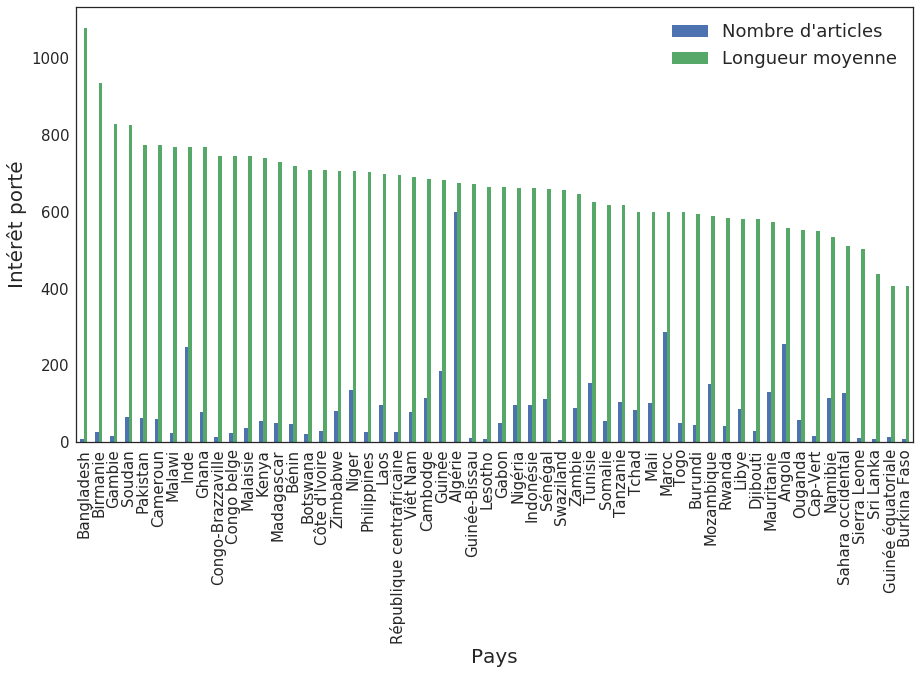

In [111]:
ax = countries_md[['articles', 'wAVG']].sort_values('wAVG', ascending=False).plot.bar()
ax.set_ylabel('Intérêt porté')
ax.legend(["Nombre d'articles",'Longueur moyenne'])
plt.savefig(fig_path + 'interest.png', bbox_inches='tight')

/home/tomoiaga/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


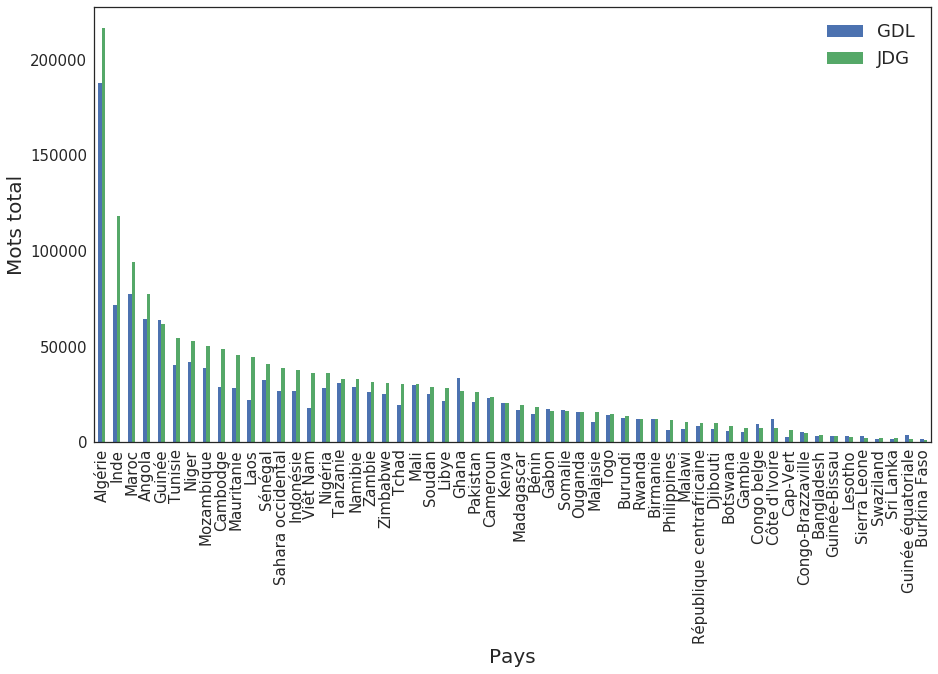

In [112]:
ax = countries_md[['wGDL', 'wJDG']].sort_values('wJDG', ascending=False).plot.bar()
ax.set_ylabel('Mots total')
ax.legend(['GDL', 'JDG'])
plt.savefig(fig_path + 'mots_total.png', bbox_inches='tight')

In [113]:
ind_by_year = countries_md.groupby(['ind_year']).count().RegEx

In [114]:
# some years are missing, so add the zeros in between
ind_by_year_aligned = pd.Series(0, index=np.arange(1945, 1996))
ind_by_year_aligned[ind_by_year.index] = ind_by_year

/home/tomoiaga/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


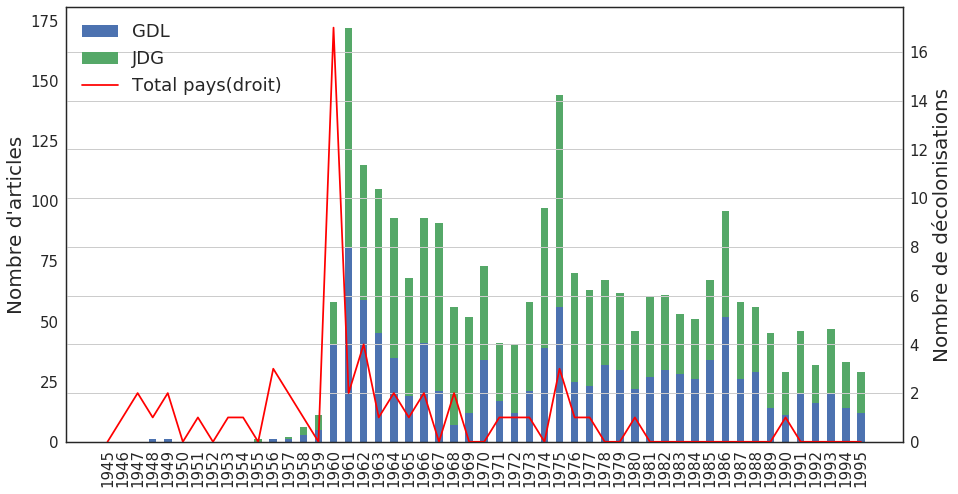

In [115]:
ax_bar = yearly_articles.plot.bar(stacked=True)
ax_bar.set_ylabel("Nombre d'articles")

ax_line = ax_bar.twinx()
ax_line.plot(ax_bar.get_xticks(), ind_by_year_aligned, 'r', label='Total pays(droit)')
ax_line.yaxis.grid(True)
ax_line.set_ylabel("Nombre de décolonisations")
ax_line.set_ylim(0)

# setup legend
bars, bar_labels  = ax_bar.get_legend_handles_labels()
line, line_labels = ax_line.get_legend_handles_labels()
ax_bar.legend_.remove()
ax_line.legend(bars + line, bar_labels + line_labels, loc='upper left')

plt.savefig(fig_path + 'num_decolonis.png', bbox_inches='tight')